In [4]:
import pandas as pd
import os

import warnings
warnings.filterwarnings("ignore")

In [5]:
df_anomalies = pd.read_csv(os.path.join(os.getcwd(), "full_reconstruction.csv"))
product_codes_path=r"dataset/product_codes_HS22_V202401b.csv"
product_codes = pd.read_csv(product_codes_path)

Outlier Candidates
         total_count  outlier_count  outlier_ratio
product                                           
282520             6            6.0       1.000000
280130             6            6.0       1.000000
382312             6            5.0       0.833333
260800             6            4.0       0.666667
400280             6            4.0       0.666667
282200             6            4.0       0.666667
470311             6            4.0       0.666667
720310             6            4.0       0.666667
252310             6            3.0       0.500000
292146             6            3.0       0.500000
750400            12            6.0       0.500000
470200             6            3.0       0.500000
293361             6            3.0       0.500000
440839             6            3.0       0.500000
260300             6            3.0       0.500000
901210             6            2.0       0.333333
400300             6            2.0       0.333333
870321      

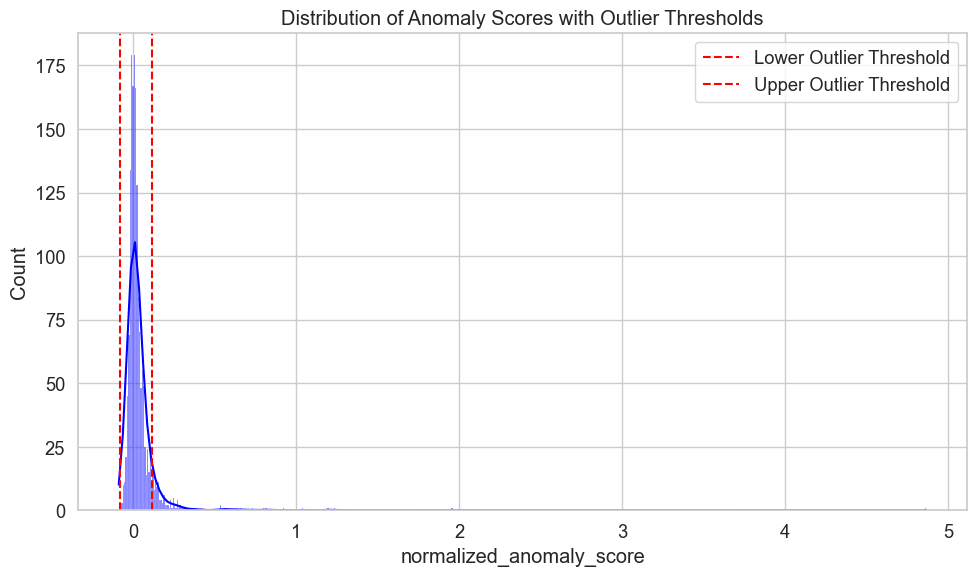

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.2)

Q1 = df_anomalies['normalized_anomaly_score'].quantile(0.25)
Q3 = df_anomalies['normalized_anomaly_score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_anomalies[
    (df_anomalies['normalized_anomaly_score'] < lower_bound) | 
    (df_anomalies['normalized_anomaly_score'] > upper_bound)
]
baseline = df_anomalies[
    (df_anomalies['normalized_anomaly_score'] >= lower_bound) & 
    (df_anomalies['normalized_anomaly_score'] <= upper_bound)
]

product_counts = df_anomalies.groupby('product')['normalized_anomaly_score'].count().rename("total_count")
outlier_counts = outliers.groupby('product')['normalized_anomaly_score'].count().rename("outlier_count")
product_summary = product_counts.to_frame().join(outlier_counts, how='left').fillna(0)
product_summary['outlier_ratio'] = product_summary['outlier_count'] / product_summary['total_count']

top20_outliers = product_summary.sort_values('outlier_ratio', ascending=False).head(20)

top20_baseline = product_summary.sort_values('outlier_ratio', ascending=True).head(20)

print("Outlier Candidates")
print(top20_outliers)

print("\nBaseline Candidates")
print(top20_baseline)

plt.figure(figsize=(10,6))
sns.histplot(df_anomalies['normalized_anomaly_score'], kde=True, color='blue')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(upper_bound, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.title("Distribution of Anomaly Scores with Outlier Thresholds")
plt.legend()
plt.tight_layout()
plt.savefig("graphics/distribution_anomalies.png", dpi=300, bbox_inches="tight")
plt.show()

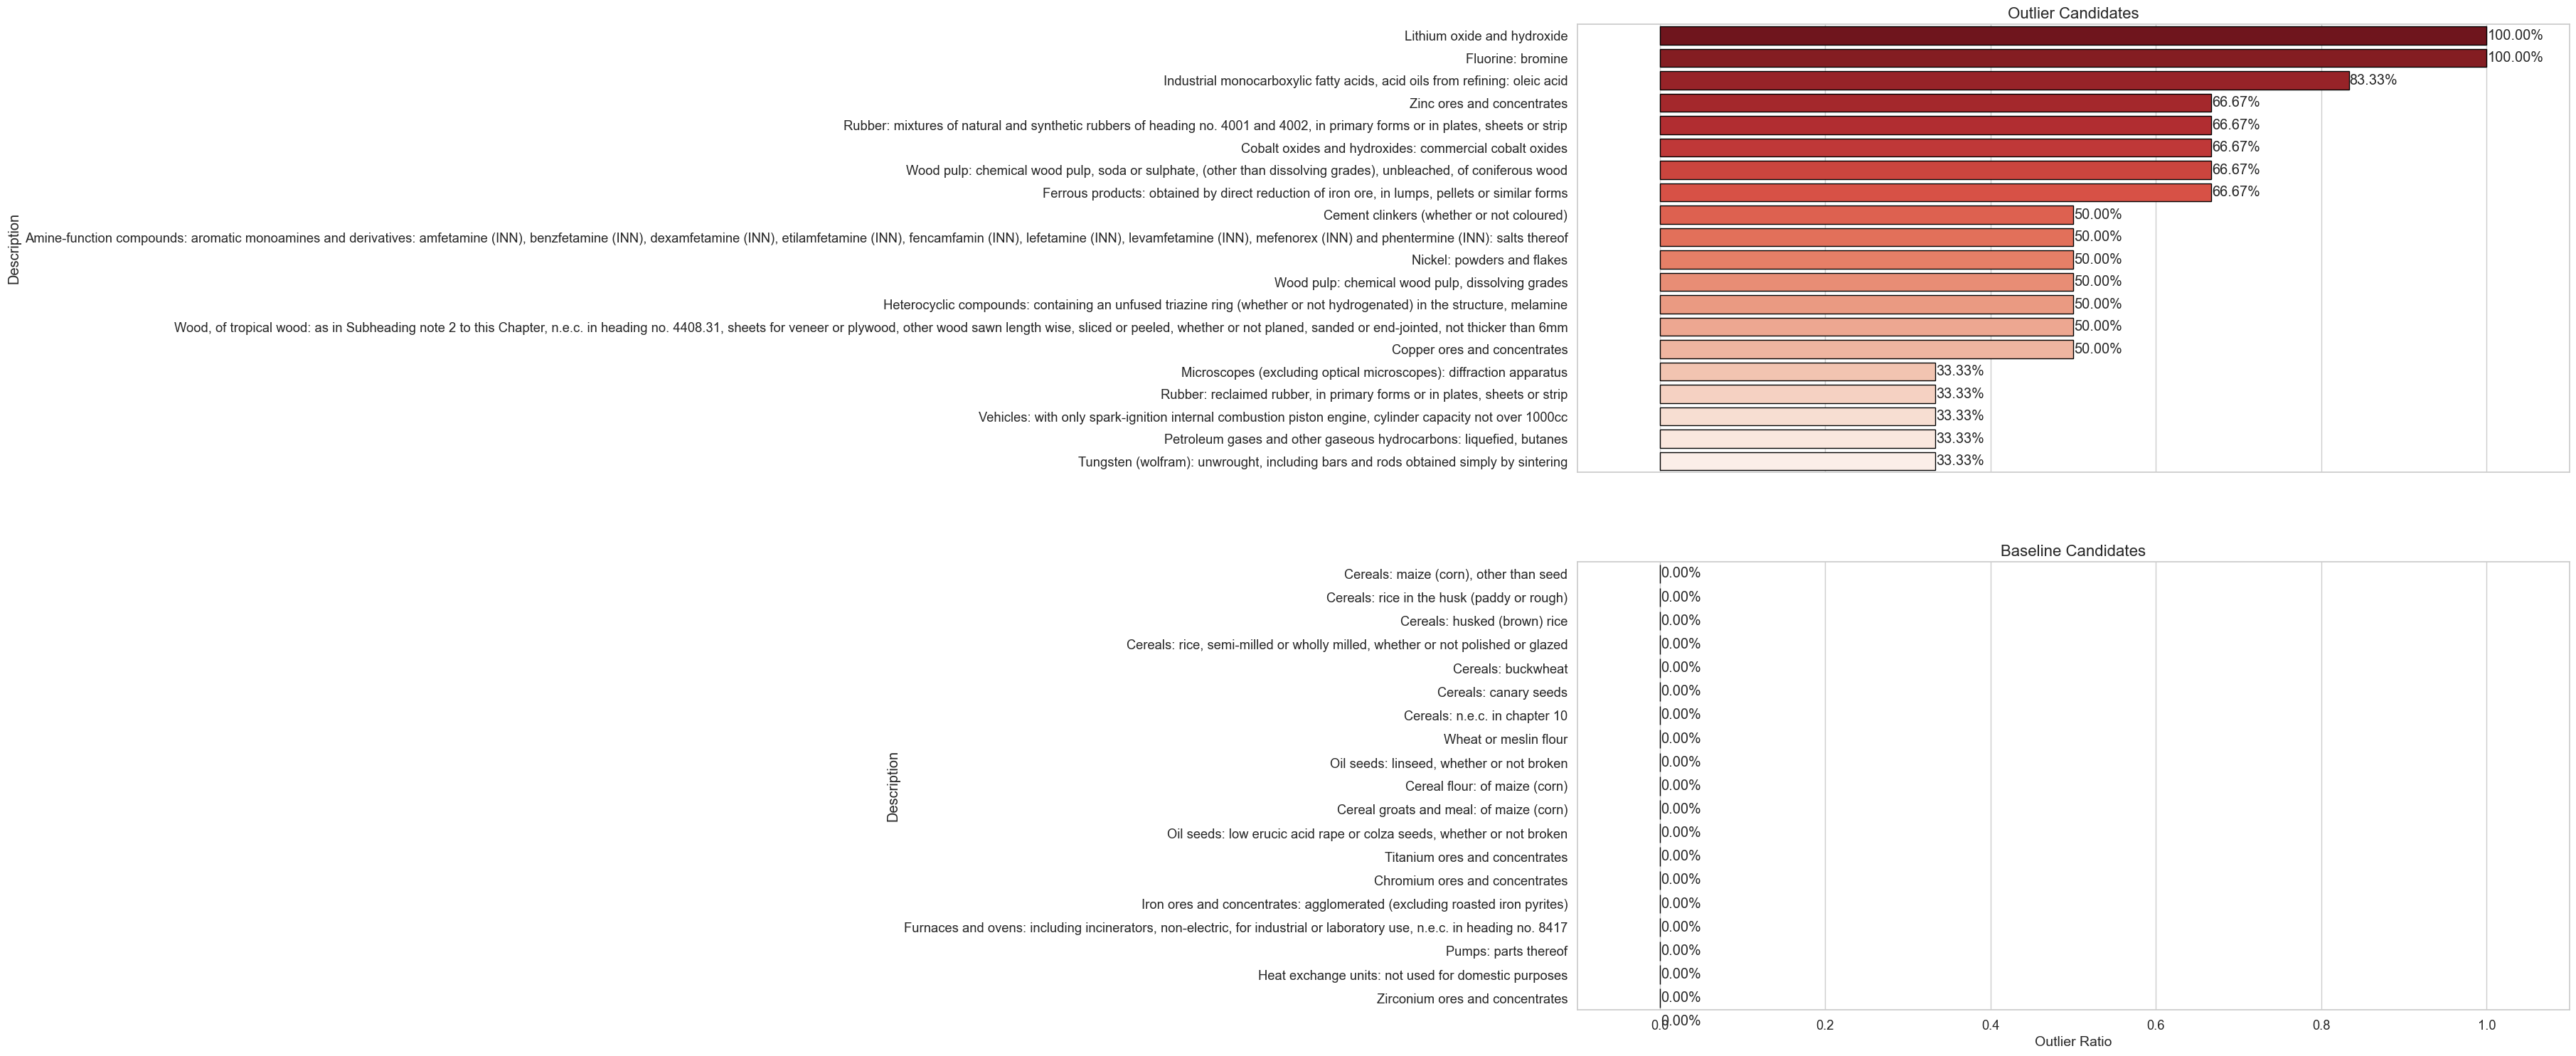

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

top20_outliers_merged = (
    top20_outliers
    .reset_index()  
    .merge(product_codes[['code', 'description']], 
           how='left', left_on='product', right_on='code')
    .drop(columns='code')
    .sort_values('outlier_ratio', ascending=False)
)

top20_baseline_merged = (
    top20_baseline
    .reset_index()
    .merge(product_codes[['code', 'description']], 
           how='left', left_on='product', right_on='code')
    .drop(columns='code')
    .sort_values('outlier_ratio', ascending=True)
)

sns.set_theme(style="whitegrid", font_scale=1.2)

max_x = max(top20_outliers_merged['outlier_ratio'].max(), top20_baseline_merged['outlier_ratio'].max())
min_x = min(top20_outliers_merged['outlier_ratio'].min(), top20_baseline_merged['outlier_ratio'].min())

x_margin = (max_x - min_x) * 0.1
if x_margin == 0:
    x_margin = 0.05

x_lower = min_x - x_margin
x_upper = max_x + x_margin

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 18), sharex=True)

sns.barplot(
    x='outlier_ratio', y='description', 
    data=top20_outliers_merged, 
    palette='Reds_r', edgecolor='black', ax=ax1
)
ax1.set_title("Outlier Candidates", fontsize=16)
ax1.set_xlim(x_lower, x_upper)
ax1.set_xlabel("")
ax1.set_ylabel("Description")

for i, val in enumerate(top20_outliers_merged['outlier_ratio']):
    ax1.text(val + 0.001, i, f"{val:.2%}", va='center', ha='left')

sns.barplot(
    x='outlier_ratio', y='description', 
    data=top20_baseline_merged, 
    palette='Greens', edgecolor='black', ax=ax2
)
ax2.set_title("Baseline Candidates", fontsize=16)
ax2.set_xlim(x_lower, x_upper)
ax2.set_xlabel("Outlier Ratio", fontsize=14)
ax2.set_ylabel("Description")

for i, val in enumerate(top20_baseline_merged['outlier_ratio']):
    ax2.text(val + 0.001, i, f"{val:.2%}", va='center', ha='left')

plt.tight_layout()
plt.savefig("graphics/top20_outliers_baseline.png", dpi=300, bbox_inches="tight")
plt.show()
